In [1]:
!pip install wget
!pip install wandb

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6cb35dc91b9c31b780faac195b3dea9ec0740efdaa0a45a5afe319d3b9d28e8e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.8 MB 6.4 MB/s 
     |████████████████████████████████| 144 kB 77.4 MB/s 
     |████████████████████████████████| 181 kB 61.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=698863290a53af046d2273e9ec9735d9e3f30e8afcfe1aed18c9f22a4f35b4de
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
!nvidia-smi

Fri Apr  8 01:24:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from wandb.keras import WandbCallback

In [3]:
import os
from os.path import exists
import sys
import requests
import zipfile
import wget
#sys.path.append('../utility/')
#from  utility.Dataset import Dataset as ds
#from  utility.CNN import CNN as cnn
seed=42

In [4]:
cwd = os.getcwd()
train_dir='inaturalist_12K/train/'
test_dir='inaturalist_12K/val/'
classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

In [33]:

import os
from os.path import exists
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import cv2
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
      file_exists = exists('./nature_12K.zip')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip')
        print('download Complete')
      extract_exists = exists('./inaturalist_12K/')   
      if(extract_exists==False):  
        savePath=cwd
        savefile='./nature_12K.zip'
        print('Extracting..')
        with zipfile.ZipFile(savefile, 'r') as zip_ref:
            zip_ref.extractall(savePath)
        print('Complete')
       
        
    def showRandomImageOfEveryClass(self,imagesize=128):
       classes=['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
       imagePath='./inaturalist_12K/train'
       listImages=[]
       columns = 5
       rows = 5
       imcount=1
       
       for i in classes:
           p=imagePath+'/'+i
           files=os.listdir( p)
           img=random.choice(files)
           imgplt=mpimg.imread( p+'/'+str(img))
           imgplt=cv2.resize(imgplt,(imagesize,imagesize)) 
           listImages.append(imgplt)
           #plt.imshow(imgplt)
           #fig.add_subplot(rows, columns, imcount)
           #imcount+=1
           #plt.axis('off')
           #plt.title(i) 
       
       _, axs = plt.subplots(1, 10, figsize=(15, 15))
       axs = axs.flatten()
       for img, ax,cls in zip(listImages, axs,classes):
         
           ax.imshow(img)
           ax.axis('off')
           ax.set_title(str(cls))
       plt.show()
    
    
    def import_dataset(self,seed,image_size=128,augment_data=False):
        #All variables 
        cwd=os.getcwd()
        batchsize=32
        image_size=image_size
        train_dir = './inaturalist_12K/train/'
        test_dir = './inaturalist_12K/val/'
        print('Training Dataset')

        #perform Augmentation if augment_data=True
        if augment_data:
            train_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=90,
                                          zoom_range=0.2,
                                          shear_range=0.2,
                                          validation_split=0.1,
                                          horizontal_flip=True)
            test_datagen = ImageDataGenerator(rescale=1./255)
        else:
            train_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
            test_datagen = ImageDataGenerator(rescale=1./255)

        train_ds = train_datagen.flow_from_directory(train_dir,subset="training", class_mode='sparse',color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        val_ds = train_datagen.flow_from_directory(train_dir,subset="validation",class_mode='sparse', color_mode='rgb',target_size=(image_size, image_size), batch_size=batchsize)
        print('')
        print('Test Dataset')
        test_ds = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size) ,class_mode='sparse',color_mode='rgb',batch_size=30)
    



    
        return train_ds,val_ds, test_ds
               

In [34]:
"""
Following functions used to construct an CNN network

Parameters
---------
filters: number of filters in each layer.This is mendatory parameter
size_of_filters: Size of filters in each layers
BatchNormalization: If true apply batch normalisation after each layer
number_of_neurons_dense_layer : Dense layer neuron 
number_of_classes: Total number of classes
dropout: dropout rate
BatchNormalization: Whether batch normalization applied

filterSize: 
size of filter in first layer .mostly used only when filterOrganization selected


filterOrganization:
Some default configuaration selected.Optionally user can pass there own custom filter configuration from
"filterOrganization" parameter.This is optional parameter.Values are following:
               
config_all_same:[64,64,64,64,64]
config_incr : [16,32,64,128,256]
config_decr: [256,128,64,32,16]
config_alt_incr: [32,64,32,64,32]  
config_alt_decr:[64,32,64,32,64]  

***If any other values provided "filterOrganization" then it select configuration applied "filters"            
 
"""
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPool2D,MaxPooling3D , Flatten , Dropout, Dense, Activation, BatchNormalization
class CNN:

    def train(self,model,train_ds,val_ds,optimizer="adam",lr=0.0001,epoch=5,wandbLog=False):
        if(optimizer=="sgd"):
          model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr,momentum=0.9),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 
        else:
          model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),\
              loss=[tf.keras.losses.SparseCategoricalCrossentropy()],\
              metrics=['accuracy']
              ) 
        
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
        if(wandbLog):
          hist=model.fit(train_ds, epochs=epoch,validation_data=val_ds,callbacks=[early_stop,WandbCallback()])
        else:
          hist=model.fit(train_ds, epochs=epoch,validation_data=val_ds,callbacks=[early_stop])
     
        return model
    def setUp(self,filters=[16,32,64,128,256],\
            size_of_filters= [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)],\
            activation_function="relu",\
            number_of_neurons_dense_layer=256,\
            number_of_classes=10,\
            dropout=0,\
            BatchNormalization=True,
            filterSize=32,
            filterOrganization='custom',
            imsize=300
           ):
     
        if(filterOrganization=='config_all_same'):
            filters=[64,64,64,64,64]
        if(filterOrganization=='config_incr'):
            filters=[16,32,64,128,256]
        if(filterOrganization=='config_decr'):
            filters=[256,128,64,32,16]
        if(filterOrganization=='config_alt_incr'):
            filters=[32,64,32,64,32]     
        if(filterOrganization=='config_alt_decr'):
            filters=[64,32,64,32,64]

        model = Sequential()
        num_of_filters=len(filters)
        model.add(Conv2D(filters[0], size_of_filters[0],input_shape=(imsize,imsize,3)))
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) 
        model.add(MaxPooling2D((2,2)))

        for i in range(num_of_filters-1):
            model.add(Conv2D(filters[i+1], size_of_filters[i+1]))

            model.add(Activation(activation_function))
            if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization()) 
            model.add(MaxPooling2D((2,2)))


        model.add(Flatten())

        model.add(Dense(number_of_neurons_dense_layer,activation=activation_function)) 
        if BatchNormalization:
                model.add(tf.keras.layers.BatchNormalization())
        if(dropout>0):
            model.add(Dropout(dropout))
        model.add(Dense(number_of_classes, activation='softmax'))
        return model



In [7]:
ds=Dataset()

In [8]:
ds.downloadDataSet()

downloading....
download Complete
Extracting..
Complete


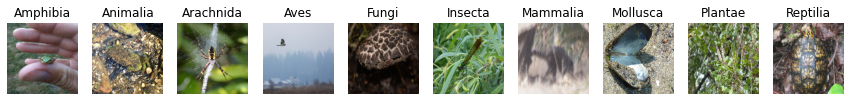

In [9]:
ds.showRandomImageOfEveryClass()

In [10]:
train_ds,val_ds,test_ds=ds.import_dataset(seed=42,image_size=300,augment_data=True)

Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.


In [41]:
sweep_config = {
  "name": "DLAssignmentQuesA",
  "method": "bayes",
  "metric": {
      "name": "validation_loss",
      "goal": "minimize",
  },
  
  "parameters": {
        "augment_data":{
          "values":[True,False]    
        },
        "image_shape":{
            "values":[128,224,300]      

        },
        "lr":{
          "values":[1e-4,1e-5]  
        },
        "optimizer":{
          "values":['adam']  
        },
        "filterOrganization":{"values":['config_Custom[256,256,256,256,256]','config_all_same','config_incr','config_decr','config_alt_incr','config_alt_decr']},
        "dropout":{ "values": [0.2,0.3,0.4]},
        "BatchNormalization":{ "values": [True,False]},
        "activation_function": {"values": ["relu","LeakyReLU"]},
        "number_of_neurons_in_the_dense_layer":{"values":[256,512]}
        }
    }
               


In [25]:
import wandb

In [38]:
# This is the main function to use to train/fine-tune the model using wandb runs
def train_wandb():
    run = wandb.init()
  
    config=wandb.config
    # Set the run name
    name="image_shape("+ str(config["image_shape"]) + ")_"
    name = " Augment_Data(" + str(config["augment_data"]) + ")_"
    name += " filterOrganization(" + str(config["filterOrganization"]) + ")_"
    name += "dropout(" + str(config["dropout"])+ ")_"
    name += "activation_function(" + str(config["activation_function"])+ ")_"
    name += "number_of_neurons_in_the_dense_layer(" + str(config["number_of_neurons_in_the_dense_layer"]) + ")_"
    name += "batchNormalization(" + str(config["BatchNormalization"]) + ")"
    name += "lr(" + str(config["lr"]) + ")"
    name += "optimizer(" + str(config["optimizer"]) + ")"
    wandb.run.name = name[:-1]
    number_of_neurons_in_the_dense_layer=config["number_of_neurons_in_the_dense_layer"]
    augment_data=config["augment_data"]
    filterOrganization=config["filterOrganization"]
    activation_function=config["activation_function"]
    BatchNormalization=config["BatchNormalization"]
    dropout=config["dropout"]
    optimizer=config["optimizer"]
    lr=config["lr"]
    #sample inputs
    image_size=config["image_shape"]
    ds=ds=Dataset()
    train_ds,val_ds,test_ds=ds.import_dataset(seed=42,image_size=image_size,augment_data=augment_data)
    cnn=CNN()
    no_of_filters = []
    size_of_filters = [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
    
    number_of_classes=10
    model=cnn.setUp(no_of_filters,size_of_filters,\
              activation_function,\
              number_of_neurons_in_the_dense_layer,\
              number_of_classes,\
              dropout,BatchNormalization,\
              filterSize=16,\
             filterOrganization=filterOrganization,imsize=image_size) 
    
    epoch=12
    wandbLog=True
    model=cnn.train(model,train_ds,val_ds,optimizer,lr,epoch,wandbLog)
    
 


In [42]:
sweep_id = wandb.sweep(sweep_config, entity="kankan-jana", project="CS6910_Assignment-2")

Create sweep with ID: p1x9o8e7
Sweep URL: https://wandb.ai/kankan-jana/CS6910_Assignment-2/sweeps/p1x9o8e7


In [43]:

#wandb.agent("5thdrpw5", train_wandb)
wandb.agent(sweep_id, train_wandb)

wandb: Agent Starting Run: d9spcmyy with config:
wandb: 	BatchNormalization: True
wandb: 	activation_function: LeakyReLU
wandb: 	augment_data: False
wandb: 	dropout: 0.3
wandb: 	filterOrganization: config_all_same
wandb: 	image_shape: 224
wandb: 	lr: 0.0001
wandb: 	number_of_neurons_in_the_dense_layer: 512
wandb: 	optimizer: adam


Training Dataset
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.

Test Dataset
Found 2000 images belonging to 10 classes.
Epoch 1/12
  6/282 [..............................] - ETA: 1:20 - loss: 3.3091 - accuracy: 0.1042

wandb: Ctrl + C detected. Stopping sweep.
